This notebook is an implementation of controlling perceptual factors in Neural Style Transfer. This code is based on findings from the following paper:

&nbsp; &nbsp; &nbsp; &nbsp; *Controlling Perceptual Factors in Neural Style Transfer*
<br />&nbsp; &nbsp; &nbsp; &nbsp; by Leon A. Gatys, Alexander S. Ecker, Matthias Bethge, Aaron Hertzmann, and Eli Shechtman.
<br />&nbsp; &nbsp; &nbsp; &nbsp; arXiv (2016). https://arxiv.org/pdf/1611.07865


# Experimenting with Spatial Control

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import IPython.display as display

## Getting the Images

In [2]:
# *****************************************************************************
# To get this code to work on your system, you may need to re-write this cell,
# depending on where you plan to run these files from. As you can see, I chose
# to put the files on my Google Drive and run them from there using Google
# Colab. You may choose another approach, such as running files locally.
# *****************************************************************************
from google.colab import drive
drive.mount('/content/drive')

base_image_path = "/content/drive/MyDrive/Colab Notebooks/CSCI_S-89/Final_Project/Images/Hinton.jpg"
mask_image_path = "/content/drive/MyDrive/Colab Notebooks/CSCI_S-89/Final_Project/Images/Hinton_mask.jpg"
style_image_path = "/content/drive/MyDrive/Colab Notebooks/CSCI_S-89/Final_Project/Images/GeorgeFloyd.jpg"

Mounted at /content/drive


In [3]:
# Make sure the images are a similar size. Widely differing sizes can make the
# style transfer more difficult.
original_width, original_height = keras.utils.load_img(base_image_path).size
img_height = 400
img_width = round(original_width * img_height / original_height)

In [4]:
# Opens, reizes, and converys an image into a numpy array.
def preprocess_image(image_path):
    img = keras.utils.load_img(image_path, target_size=(img_height, img_width))
    img = keras.utils.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    # Transform the the array (for use with VGG19 ImageNet).
    img = keras.applications.vgg19.preprocess_input(img)
    return img

# Converts a numpy array back into an image.
def deprocess_image(img):
    img = img.reshape((img_height, img_width, img.shape[-1]))
    # Zero-center the values by removing the mean pixel value from ImageNet.
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    # Convert the images from BGR to RGB.
    img = img[:, :, ::-1]
    img = np.clip(img, 0, 255).astype("uint8")
    return img

# Loads a mask image.
def load_mask(mask_path):
    mask = keras.utils.load_img(mask_path, target_size=(img_height, img_width), color_mode='grayscale')
    mask = keras.utils.img_to_array(mask)
    mask = mask / 255.0  # Normalize to [0, 1]
    return mask

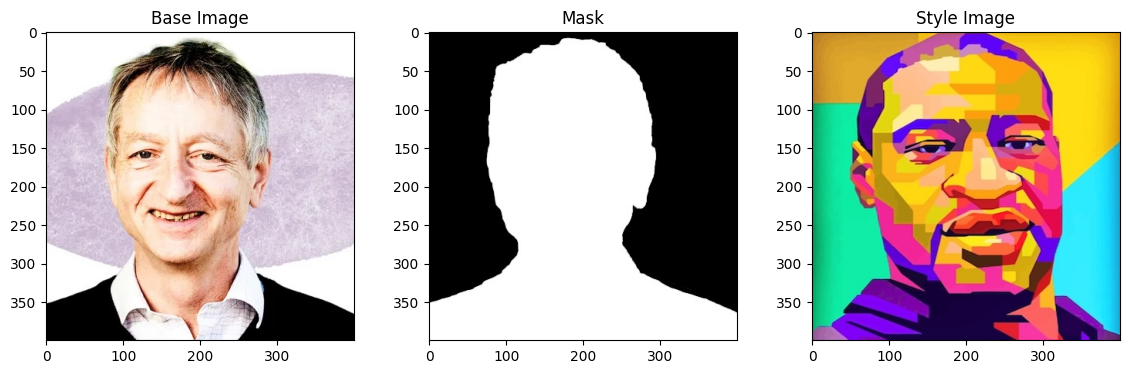

In [5]:
# Let's have a look at the base image, the mask, and the style image...
plt.figure(figsize=(14, 4))

plt.subplot(1, 3, 1)
base_image = keras.utils.load_img(base_image_path)
plt.imshow(base_image)
plt.title("Base Image")

plt.subplot(1, 3, 2)
mask_image = keras.utils.load_img(mask_image_path)
plt.imshow(mask_image, cmap="gray")
plt.title("Mask")

plt.subplot(1, 3, 3)
style_image = keras.utils.load_img(style_image_path)
plt.imshow(style_image)
plt.title("Style Image")
plt.show()

In [6]:
base_image = preprocess_image(base_image_path)
mask_image = load_mask(mask_image_path)
style_image = preprocess_image(style_image_path)
generated_image = tf.Variable(preprocess_image(base_image_path))

## Setting up the Network

In [7]:
model = keras.applications.vgg19.VGG19(weights="imagenet", include_top=False)
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

# This returns the activation values for every target layer (as a dict).
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


## Choosing the Content and Style Layers

In [8]:
content_layer_name = "block5_conv2"
style_layer_names = ["block1_conv1", "block2_conv2", "block3_conv3", "block4_conv2", "block5_conv3"]

## Defining the Loss Functions

In [9]:
content_weight = 2.5e-8
style_weight = 1e-2
total_variation_weight = 1e-2

def content_loss(base_img, generated_img):
    # Compute the mean squared error between the two images.
    return tf.reduce_sum(tf.square(generated_img - base_img))

def gram_matrix(x):
    # Compute the Gram matrix.
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram

def style_loss(style_img, generated_img):
    # Compute the Gram matrices of the style and combination images.
    S = gram_matrix(style_img)
    C = gram_matrix(generated_img)
    channels = 3
    size = img_height * img_width
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

def total_variation_loss(x):
    # Compute the total variation loss, which operates on the generated image.
    a = tf.square(x[:, : img_height - 1, : img_width - 1, :] - x[:, 1:, : img_width - 1, :])
    b = tf.square(x[:, : img_height - 1, : img_width - 1, :] - x[:, : img_height - 1, 1:, :])
    return tf.reduce_sum(tf.pow(a + b, 1.25))

def compute_loss(generated_image, base_image, style_image, mask_image):
    input_tensor = tf.concat([base_image, style_image, generated_image], axis=0)
    features = feature_extractor(input_tensor)

    # Initialize the loss to zero
    loss = tf.zeros(shape=())

    # Add content loss
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    generated_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(base_image_features, generated_features)

    # Add style loss
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_features = layer_features[1, :, :, :]
        generated_features = layer_features[2, :, :, :]
        style_loss_value = style_loss(style_features, generated_features)
        loss += (style_weight / len(style_layer_names)) * style_loss_value

    # Add total variation loss
    loss += total_variation_weight * total_variation_loss(generated_image)

    # After computing the content, style, and total variation losses, the mask
    # is applied. The loss is augmented to ensure that the masked areas remain
    # as the base image. This is done by adding a term that penalizes changes
    # in the masked areas.
    mask_3d = tf.concat([mask_image, mask_image, mask_image], axis=-1)
    inverted_mask = 1 - mask_3d
    loss += tf.reduce_sum(tf.square(generated_image * inverted_mask - base_image * inverted_mask))

    return loss

## Performing Gradient Descent

array([[[253, 251, 253],
        [252, 249, 251],
        [255, 252, 253],
        ...,
        [254, 249, 251],
        [252, 249, 251],
        [254, 252, 253]],

       [[253, 251, 253],
        [252, 247, 251],
        [255, 249, 253],
        ...,
        [255, 248, 251],
        [253, 248, 250],
        [254, 251, 252]],

       [[254, 251, 253],
        [254, 246, 251],
        [255, 247, 253],
        ...,
        [255, 248, 250],
        [253, 248, 249],
        [254, 251, 252]],

       ...,

       [[  0,   0,   6],
        [  0,   0,   7],
        [  2,   0,  21],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,  23]],

       [[  0,   0,   0],
        [  0,   0,   4],
        [  0,   0,  18],
        ...,
        [  0,   0,   0],
        [  0,   0,   6],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   5],
        ...,
        [  0,   0,  10],
        [  0,   0,  26],
        [  0,   0,   0]]], dtype=uint8)
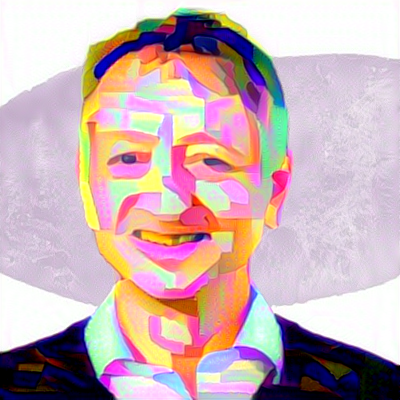

Train step: 4000


In [10]:
# Make the training step faster by compiling it as a tf.function.
@tf.function
def compute_loss_and_grads(generated_image, base_image, style_image, mask_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(generated_image, base_image, style_image, mask_image)
    grads = tape.gradient(loss, generated_image)
    return loss, grads

iterations = 4000

# Create a new optimizer for each set of weights
optimizer = keras.optimizers.RMSprop(
    learning_rate=tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.1, decay_steps=100, decay_rate=0.96
        ),
        rho=0.9,
        epsilon=1e-7
    )

for i in range(1, iterations + 1):
    # During each iteration, the loss and gradients are computed with respect
    # to the masked content, ensuring that the style transfer does not affect
    # the masked areas.
    loss, grads = compute_loss_and_grads(generated_image, base_image, style_image, mask_image)
    optimizer.apply_gradients([(grads, generated_image)])
    print(".", end='', flush=True)
    if i % 100 == 0:
        print(f"Iteration {i}: loss={loss:.2f}")
        spatial_img = deprocess_image(generated_image.numpy())
        display.clear_output(wait=True)
        display.display(spatial_img)
        print("Train step: {}".format(i))

Text(0.5, 1.0, 'Spatial Control')

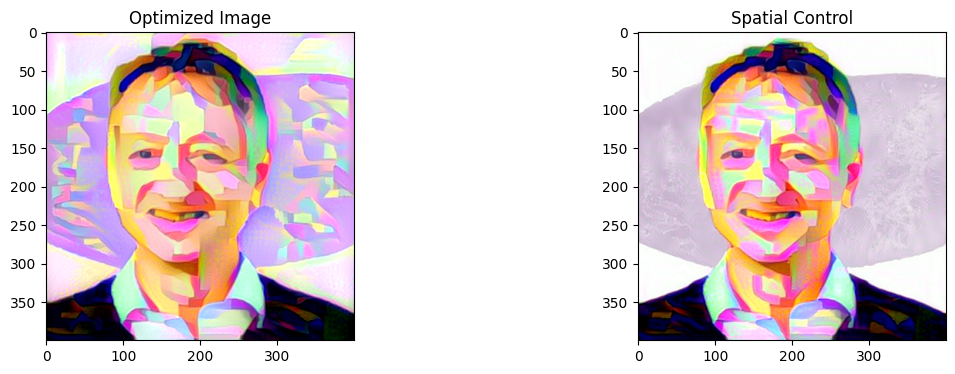

In [11]:
# *****************************************************************************
# To get this code to work on your system, you may need to re-write this cell,
# depending on where you plan to run these files from. As you can see, I chose
# to put the files on my Google Drive and run them from there using Google
# Colab. You may choose another approach, such as running files locally.
# *****************************************************************************
optimized_img_path = "/content/drive/MyDrive/Colab Notebooks/CSCI_S-89/Final_Project/Images/Optimized Generated Image.png"
optimized_img = mpimg.imread(optimized_img_path)

# Let's have a look at the base image, the mask, and the style image...
plt.figure(figsize=(14, 4))

plt.subplot(1, 2, 1)
plt.imshow(optimized_img)
plt.title("Optimized Image")

plt.subplot(1, 2, 2)
plt.imshow(spatial_img, cmap="gray")
plt.title("Spatial Control")
